This exercise is meant to show that we have the syntax tools now to do fairly complex things. We just need some practice applying them.

No tariff version


--- Round 1 ---
US Retailer: Inventory = 100, Backlog = 0
Mississauga Integrator: Inventory = 100, Backlog = 0
El Paso Compliance: Inventory = 100, Backlog = 0
Ciudad Juárez Assembler: Inventory = 100, Backlog = 0
Colorado Processor: Inventory = 100, Backlog = 0
China Manufacturer: Inventory = 140, Backlog = 0

--- Round 2 ---
US Retailer: Inventory = 100, Backlog = 0
Mississauga Integrator: Inventory = 100, Backlog = 0
El Paso Compliance: Inventory = 100, Backlog = 0
Ciudad Juárez Assembler: Inventory = 100, Backlog = 0
Colorado Processor: Inventory = 100, Backlog = 0
China Manufacturer: Inventory = 180, Backlog = 0

--- Round 3 ---
US Retailer: Inventory = 100, Backlog = 0
Mississauga Integrator: Inventory = 100, Backlog = 0
El Paso Compliance: Inventory = 100, Backlog = 0
Ciudad Juárez Assembler: Inventory = 100, Backlog = 0
Colorado Processor: Inventory = 100, Backlog = 0
China Manufacturer: Inventory = 180, Backlog = 0

--- Round 4 ---
US Retailer: Inventory = 100, Backlog = 0
Mi

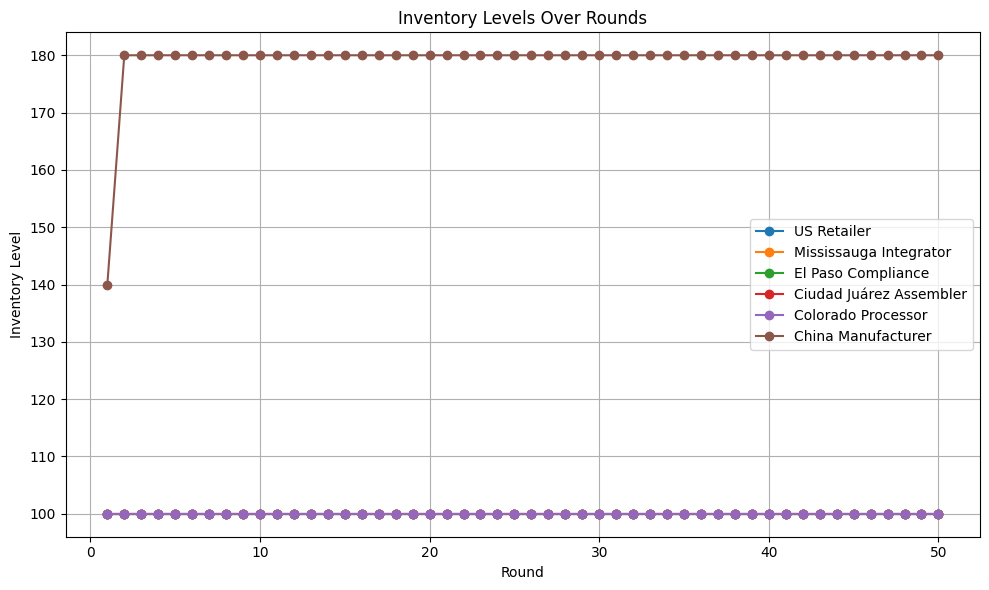

In [ ]:
import matplotlib.pyplot as plt
import random as random

# -------------------------------
# Strategy Pattern: Ordering Decision
# -------------------------------
class OrderingStrategy:
    def compute_order(self, external_order, backlog, inventory, target_inventory):
        """
        A simple Beer Game ordering rule:
            order = external_order + backlog + (target_inventory - inventory)
        In equilibrium (inventory == target_inventory and backlog == 0),
            order = external_order.
        """
        return max(external_order + backlog + (target_inventory - inventory), 0)

# -------------------------------
# Factory Pattern: Creating Agents
# -------------------------------
class SupplyChainAgentFactory:
    def __init__(self, ordering_strategy):
        self.ordering_strategy = ordering_strategy

    def create_agent(self, name, country, lead_time, initial_inventory, target_inventory, is_manufacturer=False):
        return SupplyChainAgent(
            name=name,
            country=country,
            lead_time=lead_time,
            initial_inventory=initial_inventory,
            target_inventory=target_inventory,
            ordering_strategy=self.ordering_strategy,
            is_manufacturer=is_manufacturer
        )

# -------------------------------
# Shipment Class
# -------------------------------
class Shipment:
    def __init__(self, quantity, delay, source, destination):
        self.quantity = quantity
        self.delay = delay
        self.source = source
        self.destination = destination

    def step(self):
        self.delay -= 1

# -------------------------------
# SupplyChainAgent Class
# -------------------------------
class SupplyChainAgent:
    def __init__(self, name, country, lead_time, initial_inventory, target_inventory, ordering_strategy, is_manufacturer=False):
        self.name = name
        self.country = country
        self.lead_time = lead_time
        self.inventory = initial_inventory
        self.target_inventory = target_inventory
        self.ordering_strategy = ordering_strategy
        self.is_manufacturer = is_manufacturer

        self.backlog = 0
        self.incoming_shipments = []
        self.order_from_downstream = 0
        self.order_to_upstream = 0

        self.upstream = None
        self.downstream = None

    def receive_shipments(self):
        for shipment in self.incoming_shipments[:]:
            shipment.step()
            if shipment.delay <= 0:
                self.inventory += shipment.quantity
                self.incoming_shipments.remove(shipment)

    def process_order(self):
        if self.is_manufacturer:
            order = self.order_from_downstream + self.backlog
            if self.downstream:
                self.send_shipment(order, self.downstream)
            self.order_from_downstream = 0
            self.backlog = 0
            self.order_to_upstream = 0
            return 0
        else:
            demand = self.order_from_downstream + self.backlog
            shipped = min(self.inventory, demand)
            self.inventory -= shipped
            self.backlog = demand - shipped

            if self.downstream:
                self.send_shipment(shipped, self.downstream)

            order = self.ordering_strategy.compute_order(
                self.order_from_downstream, self.backlog, self.inventory, self.target_inventory
            )
            self.order_to_upstream = order
            return order

    def send_shipment(self, quantity, destination):
        for _ in range(quantity):
            shipment = Shipment(1, destination.lead_time, self, destination)
            destination.incoming_shipments.append(shipment)

    def reset_order(self):
        self.order_from_downstream = 0

    def print_status(self):
        print(f"{self.name}: Inventory = {self.inventory}, Backlog = {self.backlog}")

# -------------------------------
# Equilibrium Seeding Function
# -------------------------------

def seed_equilibrium(agents, consumer_demand):
    for agent in agents:
        if agent.lead_time > 0:
            for d in range(1, agent.lead_time + 1):
                source = agent.upstream if agent.upstream is not None else agent
                for _ in range(consumer_demand):
                    shipment = Shipment(1, delay=d, source=source, destination=agent)
                    agent.incoming_shipments.append(shipment)

# -------------------------------
# Plotting Function for Inventory History
# -------------------------------
def plot_inventory_history(history):
    rounds = range(1, len(next(iter(history.values()))) + 1)
    plt.figure(figsize=(10, 6))
    for name, inventories in history.items():
        plt.plot(rounds, inventories, marker='o', label=name)
    plt.xlabel("Round")
    plt.ylabel("Inventory Level")
    plt.title("Inventory Levels Over Rounds")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Simulation Manager
# -------------------------------
def run_simulation(num_rounds=20, consumer_demand=40, target_inventory=100):
    strategy = OrderingStrategy()
    factory = SupplyChainAgentFactory(strategy)

    manufacturer = factory.create_agent("China Manufacturer", "China", lead_time=2,
                                       initial_inventory=target_inventory, target_inventory=target_inventory,
                                       is_manufacturer=True)
    processor = factory.create_agent("Colorado Processor", "USA", lead_time=2,
                                     initial_inventory=target_inventory, target_inventory=target_inventory)
    assembler = factory.create_agent("Ciudad Juárez Assembler", "Mexico", lead_time=2,
                                     initial_inventory=target_inventory, target_inventory=target_inventory)
    compliance = factory.create_agent("El Paso Compliance", "USA", lead_time=2,
                                      initial_inventory=target_inventory, target_inventory=target_inventory)
    integrator = factory.create_agent("Mississauga Integrator", "Canada", lead_time=2,
                                      initial_inventory=target_inventory, target_inventory=target_inventory)
    retailer = factory.create_agent("US Retailer", "USA", lead_time=0,
                                    initial_inventory=target_inventory + consumer_demand, target_inventory=target_inventory)

    retailer.upstream = integrator
    integrator.downstream = retailer
    integrator.upstream = compliance
    compliance.downstream = integrator
    compliance.upstream = assembler
    assembler.downstream = compliance
    assembler.upstream = processor
    processor.downstream = assembler
    processor.upstream = manufacturer
    manufacturer.downstream = processor

    agents = [retailer, integrator, compliance, assembler, processor, manufacturer]
    seed_equilibrium(agents, consumer_demand)
    inventory_history = {agent.name: [] for agent in agents}

    for r in range(1, num_rounds + 1):
        print(f"\n--- Round {r} ---")

        for agent in agents:
            agent.receive_shipments()

        retailer.order_from_downstream = consumer_demand

        for agent in agents:
            order = agent.process_order()
            if agent.upstream:
                agent.upstream.order_from_downstream = order

        for agent in agents:
            inventory_history[agent.name].append(agent.inventory)
            agent.print_status()

        for agent in agents:
            agent.reset_order()

    plot_inventory_history(inventory_history)

if __name__ == "__main__":
    run_simulation(num_rounds=50, consumer_demand=40, target_inventory=100)


With Tariffs Instrumentalized as a % chance of delay


--- Round 1 ---
US Retailer: Inventory = 100, Backlog = 0
Mississauga Integrator: Inventory = 100, Backlog = 0
El Paso Compliance: Inventory = 100, Backlog = 0
Ciudad Juárez Assembler: Inventory = 100, Backlog = 0
Colorado Processor: Inventory = 100, Backlog = 0
China Manufacturer: Inventory = 140, Backlog = 0

--- Round 2 ---
US Retailer: Inventory = 100, Backlog = 0
Mississauga Integrator: Inventory = 100, Backlog = 0
El Paso Compliance: Inventory = 100, Backlog = 0
Ciudad Juárez Assembler: Inventory = 100, Backlog = 0
Colorado Processor: Inventory = 100, Backlog = 0
China Manufacturer: Inventory = 180, Backlog = 0

--- Round 3 ---
US Retailer: Inventory = 100, Backlog = 0
Mississauga Integrator: Inventory = 100, Backlog = 0
El Paso Compliance: Inventory = 100, Backlog = 0
Ciudad Juárez Assembler: Inventory = 100, Backlog = 0
Colorado Processor: Inventory = 100, Backlog = 0
China Manufacturer: Inventory = 180, Backlog = 0

--- Round 4 ---
US Retailer: Inventory = 100, Backlog = 0
Mi

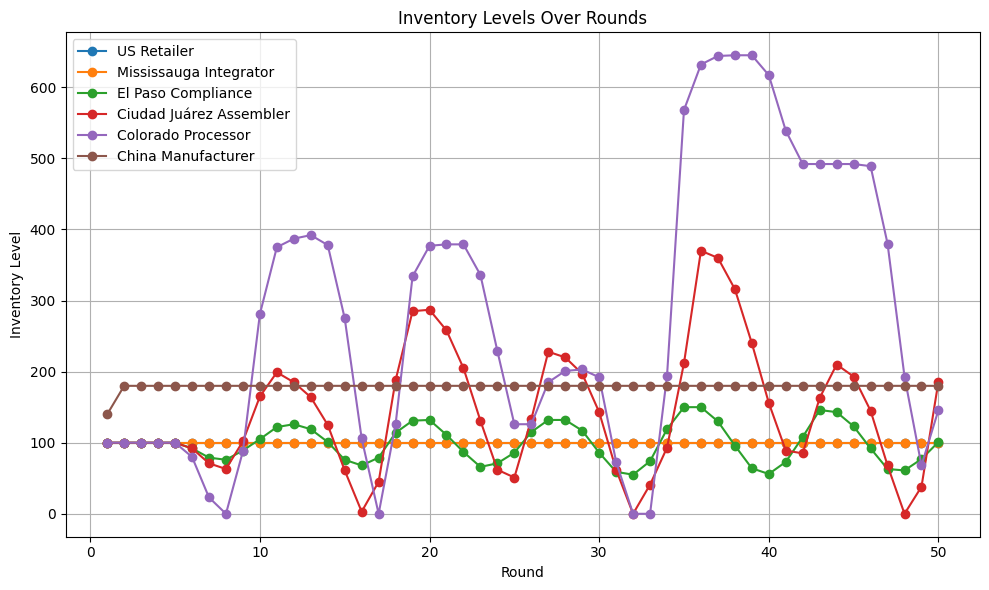

In [ ]:
import matplotlib.pyplot as plt
import random as random
# -------------------------------
# Strategy Pattern: Ordering Decision
# -------------------------------
class OrderingStrategy:
    def compute_order(self, external_order, backlog, inventory, target_inventory):
        """
        A simple Beer Game ordering rule:
            order = external_order + backlog + (target_inventory - inventory)
        In equilibrium (inventory == target_inventory and backlog == 0),
            order = external_order.
        """
        return max(external_order + backlog + (target_inventory - inventory), 0)

# -------------------------------
# Factory Pattern: Creating Agents
# -------------------------------
class SupplyChainAgentFactory:
    def __init__(self, ordering_strategy):
        self.ordering_strategy = ordering_strategy

    def create_agent(self, name, country, lead_time, initial_inventory, target_inventory, is_manufacturer=False):
        return SupplyChainAgent(
            name=name,
            country=country,
            lead_time=lead_time,
            initial_inventory=initial_inventory,
            target_inventory=target_inventory,
            ordering_strategy=self.ordering_strategy,
            is_manufacturer=is_manufacturer
        )

# -------------------------------
# Shipment Class (WITH Tariff Calculation)
# -------------------------------
class Shipment:
    def __init__(self, quantity, delay, source, destination):
        """
        :param quantity: Number of units in this shipment.
        :param delay: The delay (lead time) remaining for this shipment.
        :param source: The sending agent.
        :param destination: The receiving agent.
        """
        self.quantity = quantity  # Here quantity will always be 1
        self.delay = delay
        self.source = source
        self.destination = destination

    def step(self, apply_tariff=False):
        """Decrease the delay based on tariff if applicable."""
        if apply_tariff and self.destination.country == "USA" and self.source.country != "USA":
            if self.source.country == "China":
                self.delay -= 1 if random.random() < 0.9 else 0
            elif self.source.country in ["Mexico", "Canada"]:
                self.delay -= 1 if random.random() < 0.75 else 0
        else:
            self.delay -= 1

# -------------------------------
# SupplyChainAgent Class
# -------------------------------
class SupplyChainAgent:
    def __init__(self, name, country, lead_time, initial_inventory, target_inventory, ordering_strategy, is_manufacturer=False):
        self.name = name
        self.country = country
        self.lead_time = lead_time
        self.inventory = initial_inventory
        self.target_inventory = target_inventory
        self.ordering_strategy = ordering_strategy
        self.is_manufacturer = is_manufacturer

        self.backlog = 0
        self.incoming_shipments = []  # List of Shipment objects

        # Orders: order received from downstream and computed order to upstream.
        self.order_from_downstream = 0
        self.order_to_upstream = 0

        # Link pointers.
        self.upstream = None   # The agent from whom this node orders.
        self.downstream = None # The agent to whom this node supplies.

    def receive_shipments(self, apply_tariff=False):
        """
        Process any incoming shipments whose delay has expired.
        Add the shipment's quantity (always 1 in our quantized model) to inventory.
        """
        for shipment in self.incoming_shipments[:]:
            shipment.step(apply_tariff)
            if shipment.delay <= 0:
                self.inventory += shipment.quantity
                self.incoming_shipments.remove(shipment)

    def process_order(self):
        """
        Process the order from downstream (plus any backlog) and update inventory/backlog.
        For the manufacturer, immediately produce (and ship) exactly what was ordered.
        """
        if self.is_manufacturer:
            # Manufacturer immediately ships what is ordered (bypassing inventory/backlog concerns).
            order = self.order_from_downstream + self.backlog
            if self.downstream:
                self.send_shipment(order, self.downstream)
            self.order_from_downstream = 0
            self.backlog = 0
            self.order_to_upstream = 0
            return 0  # Manufacturer is the source; no upstream order.
        else:
            # For non-manufacturer agents.
            demand = self.order_from_downstream + self.backlog
            shipped = min(self.inventory, demand)
            self.inventory -= shipped
            self.backlog = demand - shipped

            # Ship to downstream partner using quantized shipments.
            if self.downstream:
                self.send_shipment(shipped, self.downstream)

            # Compute order to send upstream.
            order = self.ordering_strategy.compute_order(
                self.order_from_downstream, self.backlog, self.inventory, self.target_inventory
            )
            self.order_to_upstream = order
            return order

    def send_shipment(self, quantity, destination):
        """
        Instead of sending one shipment with the total quantity, send 'quantity' shipments each of size 1.
        """
        for _ in range(quantity):
            shipment = Shipment(1, destination.lead_time, self, destination)
            destination.incoming_shipments.append(shipment)

    def reset_order(self):
        self.order_from_downstream = 0

    def print_status(self):
        print(f"{self.name}: Inventory = {self.inventory}, Backlog = {self.backlog}")

# -------------------------------
# Equilibrium Seeding Function
# -------------------------------
def seed_equilibrium(agents, consumer_demand):
    """
    For each agent with a positive lead time, pre-fill its pipeline with individual shipments.
    For an agent with lead time L, add L sets of shipments with delays 1..L,
    each set containing 'consumer_demand' shipments (each of quantity 1).
    """
    for agent in agents:
        if agent.lead_time > 0:
            for d in range(1, agent.lead_time + 1):
                # Use upstream as source if available; otherwise, the agent itself.
                source = agent.upstream if agent.upstream is not None else agent
                for _ in range(consumer_demand):
                    shipment = Shipment(1, delay=d, source=source, destination=agent)
                    agent.incoming_shipments.append(shipment)

# -------------------------------
# Plotting Function for Inventory History
# -------------------------------
def plot_inventory_history(history):
    rounds = range(1, len(next(iter(history.values()))) + 1)
    plt.figure(figsize=(10, 6))
    for name, inventories in history.items():
        plt.plot(rounds, inventories, marker='o', label=name)
    plt.xlabel("Round")
    plt.ylabel("Inventory Level")
    plt.title("Inventory Levels Over Rounds")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Simulation Manager
# -------------------------------
def run_simulation(num_rounds=20, consumer_demand=40, target_inventory=100):
    apply_tariff = False
    strategy = OrderingStrategy()
    factory = SupplyChainAgentFactory(strategy)

    # Create agents.
    # For equilibrium:
    #   - The retailer (lead_time=0) gets extra inventory (target + consumer_demand)
    #   - Upstream nodes get inventory equal to the target.
    manufacturer = factory.create_agent("China Manufacturer", "China", lead_time=2,
                                          initial_inventory=target_inventory, target_inventory=target_inventory,
                                          is_manufacturer=True)
    processor    = factory.create_agent("Colorado Processor", "USA", lead_time=2,
                                          initial_inventory=target_inventory, target_inventory=target_inventory)
    assembler    = factory.create_agent("Ciudad Juárez Assembler", "Mexico", lead_time=2,
                                          initial_inventory=target_inventory, target_inventory=target_inventory)
    compliance   = factory.create_agent("El Paso Compliance", "USA", lead_time=2,
                                          initial_inventory=target_inventory, target_inventory=target_inventory)
    integrator   = factory.create_agent("Mississauga Integrator", "Canada", lead_time=2,
                                          initial_inventory=target_inventory, target_inventory=target_inventory)
    retailer     = factory.create_agent("US Retailer", "USA", lead_time=0,
                                          initial_inventory=target_inventory + consumer_demand, target_inventory=target_inventory)

    # Link agents (orders flow upstream; shipments flow downstream).
    retailer.upstream = integrator

    integrator.downstream = retailer
    integrator.upstream = compliance

    compliance.downstream = integrator
    compliance.upstream = assembler

    assembler.downstream = compliance
    assembler.upstream = processor

    processor.downstream = assembler
    processor.upstream = manufacturer

    manufacturer.downstream = processor

    # List agents from downstream to upstream.
    agents = [retailer, integrator, compliance, assembler, processor, manufacturer]

    # Seed the pipeline for agents with lead_time > 0.
    seed_equilibrium(agents, consumer_demand)

    # Record inventory history.
    inventory_history = {agent.name: [] for agent in agents}

    # Simulation loop.
    tariffs = False
    for r in range(1, num_rounds + 1):
        print(f"\n--- Round {r} ---")
        if r>5:
            tariffs=True
        # 1. Each agent receives shipments.
        for agent in agents:
            agent.receive_shipments(apply_tariff=tariffs)

        # 2. The retailer receives external consumer demand.
        retailer.order_from_downstream = consumer_demand

        # 3. Process orders (from downstream to upstream).
        for agent in agents:
            order = agent.process_order()
            if agent.upstream:
                agent.upstream.order_from_downstream = order

        # 4. Record and print status.
        for agent in agents:
            inventory_history[agent.name].append(agent.inventory)
            agent.print_status()

        # 5. Reset orders.
        for agent in agents:
            agent.reset_order()

    # Plot inventory history.
    plot_inventory_history(inventory_history)

# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    run_simulation(num_rounds=50, consumer_demand=40, target_inventory=100)


The cascading fluctuations in inventory levels is a phenomena called hte bullwhip effect. We implemented tariffs by creating a % chance of a delay in a cross border shipment. This delay alone was enough to cause the stable system to have inventory fluctuations. An alternative version could be created by having no delays in shipment, but by changing order strategy. If you're interested you could test yourself by making a version of this that caused each agent to adjust their orders. Other people have made variations where instead of inventory fluctuations the change of information in the system manifested as fluctuating prices.